# IMDB Votes Regression Project

Christian Branton

In [2]:
# Basic imports
from __future__ import print_function, division
import re
import pickle
import numpy as np
import pandas as pd

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tools.plotting import table

import requests
from collections import defaultdict
from bs4 import BeautifulSoup
%matplotlib inline

# Scraping IMDB
I start this by grabbing the basic url for the top movies from 1972 til today with wide releases

In [15]:
url = 'https://www.imdb.com/list/ls057823854/?sort=list_order,asc&st_dt=&mode=detail&page={}'

In [16]:
url_list = []
for i in range(1,100,1):
    file_url = url.format(i)
    url_list.append(file_url)

This grabs our URL pages from 1 to 100 and puts them in a list. We will use this to iterate throught each page from the list to grab 100 movies each.

In [17]:
def scrapetitle(movierank):
    movie = movie_containers[movierank]

    title = str(movie.h3.a.text)
    return title
    
def scrapegenre(movierank):
    movie = movie_containers[movierank]
    try:
        genrelist = []
        temp = (str(movie.find('span', class_ = 'genre').text).strip().split(','))
        for i in temp:
             genrelist.append(i.strip())
    except:
        genres = np.nan
    return genrelist

def scrapedur(movierank):
    movie = movie_containers[movierank]
    try:
        dur = str(movie.find('span', class_ = 'runtime').text)
        dur = int(re.sub('\D', '', dur))
    except:
        dur = np.nan
    return dur

def scraperate(movierank):
    movie = movie_containers[movierank]
    try:
        rate = str(movie.find('span', class_ = 'certificate').text).strip()
    except:
        rate = np.nan
    return rate

def scrapeyear(movierank):
    movie = movie_containers[movierank]
    try:
        year = str(movie.find('span', class_ = 'lister-item-year text-muted unbold').text).strip()
        year = int(re.sub('\D', '', year))
    except:
        year = np.nan
    return year

def scrapeimdb(movierank):
    movie = movie_containers[movierank]
    try:
        imdbrate = float(movie.find('span', class_ = 'ipl-rating-star__rating').text)
    except:
        imdbrate = np.nan
    return imdbrate

def scrapemeta(movierank):
    movie = movie_containers[movierank]
    try:
        metarate = int(movie.find('span', class_ = 'metascore favorable').text)
    except:
        metarate = np.nan
    return metarate

def scrapevotes(movierank):
    movie = movie_containers[movierank]
    try:
        votes = movie.find('span', attrs = {'name':'nv'}).text
        votes = int(re.sub('\D', '', votes))
    except:
        votes = np.nan
    return votes

def scrapegross(movierank):
    movie = movie_containers[movierank]
    try:
        gross = str(movie.findAll('span', attrs = {'name':'nv'})[1].text)
        gross = float(gross.lstrip('$').rstrip('M'))*1000000
    except:
        gross = np.nan
    return gross
    
def scrapedirec(movierank):
    movie = movie_containers[movierank]
    try:
        temp = movie.findAll('p', class_="text-muted text-small")[1]
        names = temp.findAll('a')[0]
        direc = []
        for i in names:
            direc.append(str(i))
    except:
        direc = np.nan
    return direc
    
def scrapestars(movierank):
    movie = movie_containers[movierank]
    try:
        temp = movie.findAll('p', class_="text-muted text-small")[1]
        names = temp.findAll('a')[1:]
        stars = []
        for i in names:
            stars.append(str(i.text))
    except:
        stars = np.nan
    return stars

These are our functions which we use to scrape from each movie and grab all our main features from each movie and return them so we can append them to a list later for our dictionary which we can convert into a dataframe.

In [18]:
#Create an empty dictionary for our features
keys = ['title','genres','dur','rate','year','imdbrate','metarate','votes','gross','direc','stars']
dic = {key: None for key in keys}

We then create empty lists for each feature first. Then we iterate through each item in the url list which goes through each url for each page and grabs 1 movie at a time via soup. It scrapes through that movie and appends the results to the lists and repeats through every movie and every page. Once this is done, we put them into a dictionary so we can convert it easily into a DataFrame.

In [20]:
title,genres,dur,rate,year,imdbrate,metarate,votes,gross,direc,stars = [], [] ,[] ,[] ,[] ,[] ,[] ,[] ,[] ,[],[]
for i in url_list:
    print("page: ",i)
    response = requests.get(i)
    page = response.text
    soup = BeautifulSoup(page, 'lxml')
    movie_containers = soup.findAll('div', class_ = 'lister-item mode-detail')
    for j in range(len(movie_containers)):
        title.append(scrapetitle(j))
        genres.append(scrapegenre(j))
        dur.append(scrapedur(j))
        rate.append(scraperate(j))
        year.append(scrapeyear(j))
        imdbrate.append(scrapeimdb(j))
        metarate.append(scrapemeta(j))
        votes.append(scrapevotes(j))
        gross.append(scrapegross(j))
        direc.append(scrapedirec(j))
        stars.append(scrapestars(j))
        
    
dic['title'] = title
dic['genres'] = genres
dic['dur'] = dur
dic['rate'] = rate
dic['year'] = year
dic['imdbrate'] = imdbrate
dic['metarate'] = metarate
dic['votes'] = votes
dic['gross'] = gross
dic['direc'] = direc
dic['stars'] = stars

page:  https://www.imdb.com/list/ls057823854/?sort=list_order,asc&st_dt=&mode=detail&page=1
page:  https://www.imdb.com/list/ls057823854/?sort=list_order,asc&st_dt=&mode=detail&page=2
page:  https://www.imdb.com/list/ls057823854/?sort=list_order,asc&st_dt=&mode=detail&page=3
page:  https://www.imdb.com/list/ls057823854/?sort=list_order,asc&st_dt=&mode=detail&page=4
page:  https://www.imdb.com/list/ls057823854/?sort=list_order,asc&st_dt=&mode=detail&page=5
page:  https://www.imdb.com/list/ls057823854/?sort=list_order,asc&st_dt=&mode=detail&page=6
page:  https://www.imdb.com/list/ls057823854/?sort=list_order,asc&st_dt=&mode=detail&page=7
page:  https://www.imdb.com/list/ls057823854/?sort=list_order,asc&st_dt=&mode=detail&page=8
page:  https://www.imdb.com/list/ls057823854/?sort=list_order,asc&st_dt=&mode=detail&page=9
page:  https://www.imdb.com/list/ls057823854/?sort=list_order,asc&st_dt=&mode=detail&page=10
page:  https://www.imdb.com/list/ls057823854/?sort=list_order,asc&st_dt=&mode=d

In [21]:
#Combine our dictionary into a dataframe
df = pd.DataFrame(dic)

## Pickle
Have a pickle to save our dataframe and to get it back in case we need to
### Save Pickle

In [99]:
with open('fldataframe.pkl', 'wb') as picklefile:
    pickle.dump(final_df, picklefile)

In [62]:
with open('cldataframe.pkl', 'wb') as picklefile:
    pickle.dump(df, picklefile)

In [61]:
with open('names.pkl', 'wb') as picklefile:
    pickle.dump(df2, picklefile)

 ### Reload pickle


In [ ]:
with open("cldataframe.pkl", "rb") as picklefile:
    df = pickle.load(picklefile)

In [ ]:
with open("names.pkl", "rb") as picklefile:
    df = pickle.load(picklefile)

In [5]:
with open("fldataframe.pkl", "rb") as picklefile:
    df = pickle.load(picklefile)

# Data Cleaning
## Cleaning Our Actors feature(stars)

In [23]:
#Creates a list of most common actors and the amount of roles they've had
star_dict = defaultdict(int)
for row in df['stars']:
    for name in row:
        star_dict[name] += 1

In [24]:
#Shows us our sorted list of most common actors and the amount of roles they've had
#sorted(star_dict.items(), key=lambda x:x[1], reverse=True)

In [25]:
topl = [k for k,v in star_dict.items() if v >= 20]
botl = [k for k,v in star_dict.items() if 20 > v >= 1]

In [26]:
l=[]
for row in df.stars:
    top=0
    bot=0
    for actor in row:
        if actor in topl:
            top+=1
        if actor in botl:
            bot+=1
    l.append([top,bot])

In [27]:
actor_df = pd.DataFrame(l, columns=['count_top_a','count_bot_a'])

## Cleaning Our Directors feature(direc)

In [28]:
df['direc'].isna().sum()
df['direc'].dropna(inplace=True)

In [29]:
#Creates a list of most common directors and the amount of roles they've had
direc_dict = defaultdict(int)
for row in df['direc']:
    for name in row:
        direc_dict[name] += 1

In [30]:
#Shows us our sorted list of most common directors and the amount of roles they've had
#sorted(direc_dict.items(), key=lambda x:x[1], reverse=True)

In [31]:
topl = [k for k,v in direc_dict.items() if v >= 10]
botl = [k for k,v in direc_dict.items() if 10 > v >= 1]

In [32]:
l=[]
for row in df.direc:
    top=0
    bot=0
    for direc in row:
        if direc in topl:
            top+=1
        if direc in botl:
            bot+=1
    l.append([top,bot])

In [33]:
direc_df = pd.DataFrame(l, columns=['count_top_d','count_bot_d'])

## Dummify our ratings

In [34]:
rate_df = pd.get_dummies(df.rate)

## Cleaning our Genres

In [35]:
#Creates a list of our genres and the amount of movies that have these genres as a count
genre_dict = defaultdict(int)
for row in df['genres']:
    for name in row:
        genre_dict[name] += 1

In [36]:
sorted(genre_dict.items(), key=lambda x:x[1], reverse=True)

[('Drama', 5144),
 ('Comedy', 3669),
 ('Action', 1991),
 ('Crime', 1770),
 ('Romance', 1656),
 ('Adventure', 1585),
 ('Thriller', 1411),
 ('Horror', 1128),
 ('Biography', 922),
 ('Mystery', 755),
 ('Fantasy', 715),
 ('Sci-Fi', 681),
 ('Family', 624),
 ('History', 426),
 ('Animation', 388),
 ('Music', 362),
 ('Documentary', 350),
 ('Sport', 259),
 ('War', 203),
 ('Musical', 113),
 ('Western', 100),
 ('Short', 16),
 ('Reality-TV', 7),
 ('News', 2),
 ('Talk-Show', 1)]

In [37]:
#Creates a list of our genres
temp = set()
for i in df['genres']:
    for name in i:
        temp.add(name)
gl = list(temp)

In [38]:
#.add_prefix('genres_')
genre_df = pd.get_dummies(df['genres'].apply(pd.Series).stack()).sum(level=0).add_prefix('genres_')

In [39]:
#We can see from genre_dict as well as from our domain knowledge that short, reality-TV, News, 
#and talk-show do not have many points and/or are not generally considered real movie genres so
#we remove them from our dummy variables
genre_df = genre_df.drop(['genres_Short', 'genres_Reality-TV', 'genres_News', 'genres_Talk-Show'], axis=1)


## Combine cleaned and dummified features
Join our recently generated dataframes back into our main dataframe

In [41]:
print(genre_df.isna().sum(), genre_df.shape)
print(direc_df.isna().sum(), direc_df.shape)
print(rate_df.isna().sum(), rate_df.shape)
print(actor_df.isna().sum(), actor_df.shape)

genres_Action         0
genres_Adventure      0
genres_Animation      0
genres_Biography      0
genres_Comedy         0
genres_Crime          0
genres_Documentary    0
genres_Drama          0
genres_Family         0
genres_Fantasy        0
genres_History        0
genres_Horror         0
genres_Music          0
genres_Musical        0
genres_Mystery        0
genres_Romance        0
genres_Sci-Fi         0
genres_Sport          0
genres_Thriller       0
genres_War            0
genres_Western        0
dtype: int64 (9892, 21)
count_top_d    0
count_bot_d    0
dtype: int64 (9812, 2)
G            0
GP           0
NC-17        0
Not Rated    0
PG           0
PG-13        0
Passed       0
R            0
TV-14        0
TV-G         0
TV-MA        0
TV-PG        0
TV-Y         0
TV-Y7        0
Unrated      0
X            0
dtype: int64 (9900, 16)
count_top_a    0
count_bot_a    0
dtype: int64 (9900, 2)


In [42]:
df = df.join(genre_df)
df = df.join(direc_df)
df = df.join(rate_df)
df = df.join(actor_df)

## Fixing our null values

In [98]:
#Counts our null values per feature
print(len(df) - df.count())
print(df.shape)

dur                   0
year                  0
imdbrate              0
votes                 0
gross                 0
genres_Action         0
genres_Adventure      0
genres_Animation      0
genres_Biography      0
genres_Comedy         0
genres_Crime          0
genres_Documentary    0
genres_Drama          0
genres_Family         0
genres_Fantasy        0
genres_History        0
genres_Horror         0
genres_Music          0
genres_Musical        0
genres_Mystery        0
genres_Romance        0
genres_Sci-Fi         0
genres_Sport          0
genres_Thriller       0
genres_War            0
genres_Western        0
count_top_d           0
count_bot_d           0
G                     0
GP                    0
NC-17                 0
Not Rated             0
PG                    0
PG-13                 0
Passed                0
R                     0
TV-14                 0
TV-G                  0
TV-MA                 0
TV-PG                 0
TV-Y                  0
TV-Y7           

In [44]:
#two thirds of this column is null so we do not have good enough data to keep this
df.metarate.isnull().sum()
df = df.drop('metarate', axis=1)

In [45]:
#Removes datapoints for announced and movies not yet made
df = df[df.year <= 2019].reset_index()

In [47]:
#as our Y variable, its better to not pollute the dataset by filling the nulls 
#(Only 5 after dropping year above 2019)
df = df.dropna(subset=['votes'], axis=0).reset_index()

In [49]:
df = df.drop('index', axis=1)
df = df.drop('level_0', axis=1)

In [50]:
#Drops 6 null values in imdbrate
df = df.dropna(subset=['imdbrate'], axis=0).reset_index()

In [52]:
#Minimal amounts of nulls (25)
df = df.dropna(subset=['dur'], axis=0).reset_index()

In [54]:
#If a datapoint has more than 2 nulls, then remove it
df = df.dropna(thresh=df.shape[1]-2)

In [56]:
#drops 20 null values from these features
df = df.dropna(subset=['count_top_d'], axis=0)
df = df.dropna(subset=['count_bot_d'], axis=0)

In [257]:
#df = df.dropna(subset=['year'], axis=0).reset_index()

In [57]:
#Fills the movies without gross values with the lowest value not $0 as these are most likely
#incredibly low budget, unheard of, or older film with no data
test = df[df.gross > 0]
test.sort_values(by='gross', ascending = True)
df['gross'].fillna(value = 10000.0, inplace=True)

In [58]:
df = df.drop('index', axis=1)
df = df.drop('level_0', axis=1)

In [59]:
df.shape

(9606, 51)

## Save titles, actors, etc. and deletes these features

In [60]:
df2 = df.copy()
df2 = df2[['stars','direc','title','genres','rate']]

df = df.drop('stars', axis=1)
df = df.drop('direc', axis=1)
df = df.drop('title', axis=1)
df = df.drop('genres', axis=1)
df = df.drop('rate', axis=1)

## Visualizing our Regression Assumptions

In [71]:
col = df.loc[:, df.columns != 'votes']
xlist = list(col.columns.values)

In [72]:
X = df[xlist]
y = df.votes

model = sm.OLS(y,X)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  votes   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     268.6
Date:                Thu, 18 Apr 2019   Prob (F-statistic):               0.00
Time:                        10:27:11   Log-Likelihood:            -1.2278e+05
No. Observations:                9606   AIC:                         2.456e+05
Df Residuals:                    9561   BIC:                         2.460e+05
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
dur                  101.1524     25.394      3.983      0.000      51.375     150.930
year                1161.4700     84.986     13.667      0.000     994.878    1328.062
imdbrate            3.316e+04    983.956     33.699      0.000    3.12e+04    3.51e+04
gross                  0.0014   2.04e-05     68.983      0.000       0.001       0.001
genres_Action       3954.4864   2737.352      1.445      0.149   -1411.304    9320.277
genres_Adventure    7830.5886   3041.490      2.575      0.010    1868.624    1.38e+04
genres_Animation   -4.062e+04   5549.296     -7.320      0.000   -5.15e+04   -2.97e+04
genres_Biography   -7640.5838   3680.182     -2.076      0.038   -1.49e+04    -426.645
genres_Comedy      -9416.8921   2510.572     -3.751      0.000   -1.43e+04   -4495.637
genres_Crime       -1305.9510   2640.911     -0.495      0.621   -6482.696    3870.794
genres_Documentary -4.276e+04   5927.369     -7.214      0.000   -5.44e+04   -3.11e+04
genres_Drama       -1.412e+04   2505.755     -5.637      0.000    -1.9e+04   -9212.993
genres_Family      -1.148e+04   4342.536     -2.643      0.008      -2e+04   -2963.136
genres_Fantasy      1.136e+04   3689.248      3.079      0.002    4128.192    1.86e+04
genres_History     -1.293e+04   4662.211     -2.772      0.006   -2.21e+04   -3786.290
genres_Horror       5444.6622   3466.762      1.571      0.116   -1350.926    1.22e+04
genres_Music       -1.239e+04   4859.075     -2.549      0.011   -2.19e+04   -2861.040
genres_Musical     -2864.5297   8465.849     -0.338      0.735   -1.95e+04    1.37e+04
genres_Mystery      2121.7222   3565.894      0.595      0.552   -4868.187    9111.631
genres_Romance     -9333.9118   2682.786     -3.479      0.001   -1.46e+04   -4075.081
genres_Sci-Fi       3.693e+04   3818.186      9.672      0.000    2.94e+04    4.44e+04
genres_Sport       -9282.5149   5650.202     -1.643      0.100   -2.04e+04    1793.080
genres_Thriller     1182.4344   2952.840      0.400      0.689   -4605.759    6970.628
genres_War          -372.7450   6417.141     -0.058      0.954    -1.3e+04    1.22e+04
genres_Western     -9661.4751   9035.091     -1.069      0.285   -2.74e+04    8049.220
count_top_d        -2.556e+06    1.7e+05    -15.027      0.000   -2.89e+06   -2.22e+06
count_bot_d        -2.561e+06    1.7e+05    -15.032      0.000   -2.89e+06   -2.23e+06
G                   3.087e+04   7319.092      4.217      0.000    1.65e+04    4.52e+04
GP                 -4.028e+04   8.68e+04     -0.464      0.643    -2.1e+05     1.3e+05
NC-17               5.074e+04   1.92e+04      2.638      0.008     1.3e+04    8.84e+04
Not Rated           1.454e+04   5194.149      2.800      0.005    4363.178    2.47e+04
PG                  1.924e+04   4660.706      4.129      0.000    1.01e+04    2.84e+04
PG-13               3.033e+04   4617.4

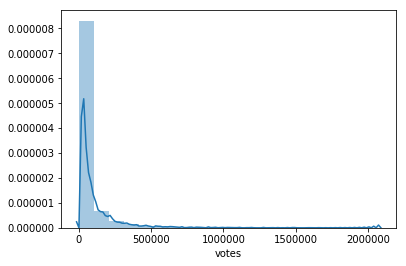

In [73]:
sns.distplot(df['votes'], bins=20);

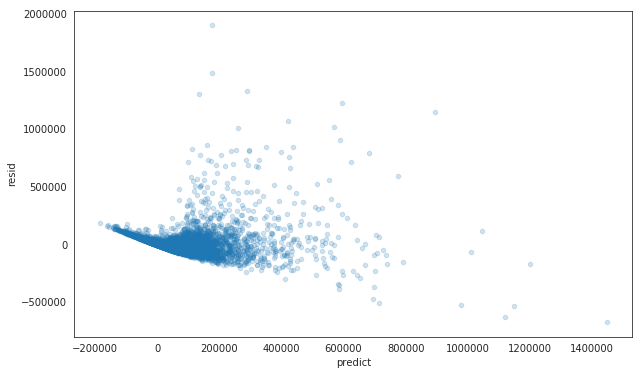

In [74]:
df['predict']=fit.predict(X)
df['resid']=df.votes-df.predict
with sns.axes_style('white'):
    plot=df.plot(kind='scatter',
                  x='predict',y='resid',alpha=0.2,figsize=(10,6))

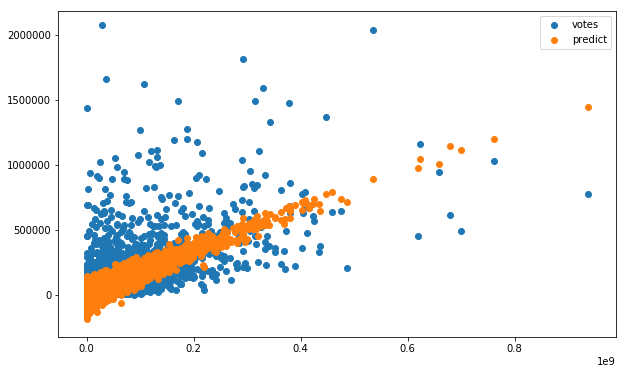

In [75]:
# quick reg plot
fig = plt.figure(figsize=(10,6))
plt.scatter(df.gross,df.votes)
plt.scatter(df.gross,df.predict)
plt.legend();

## Getting some basic visualization of our data

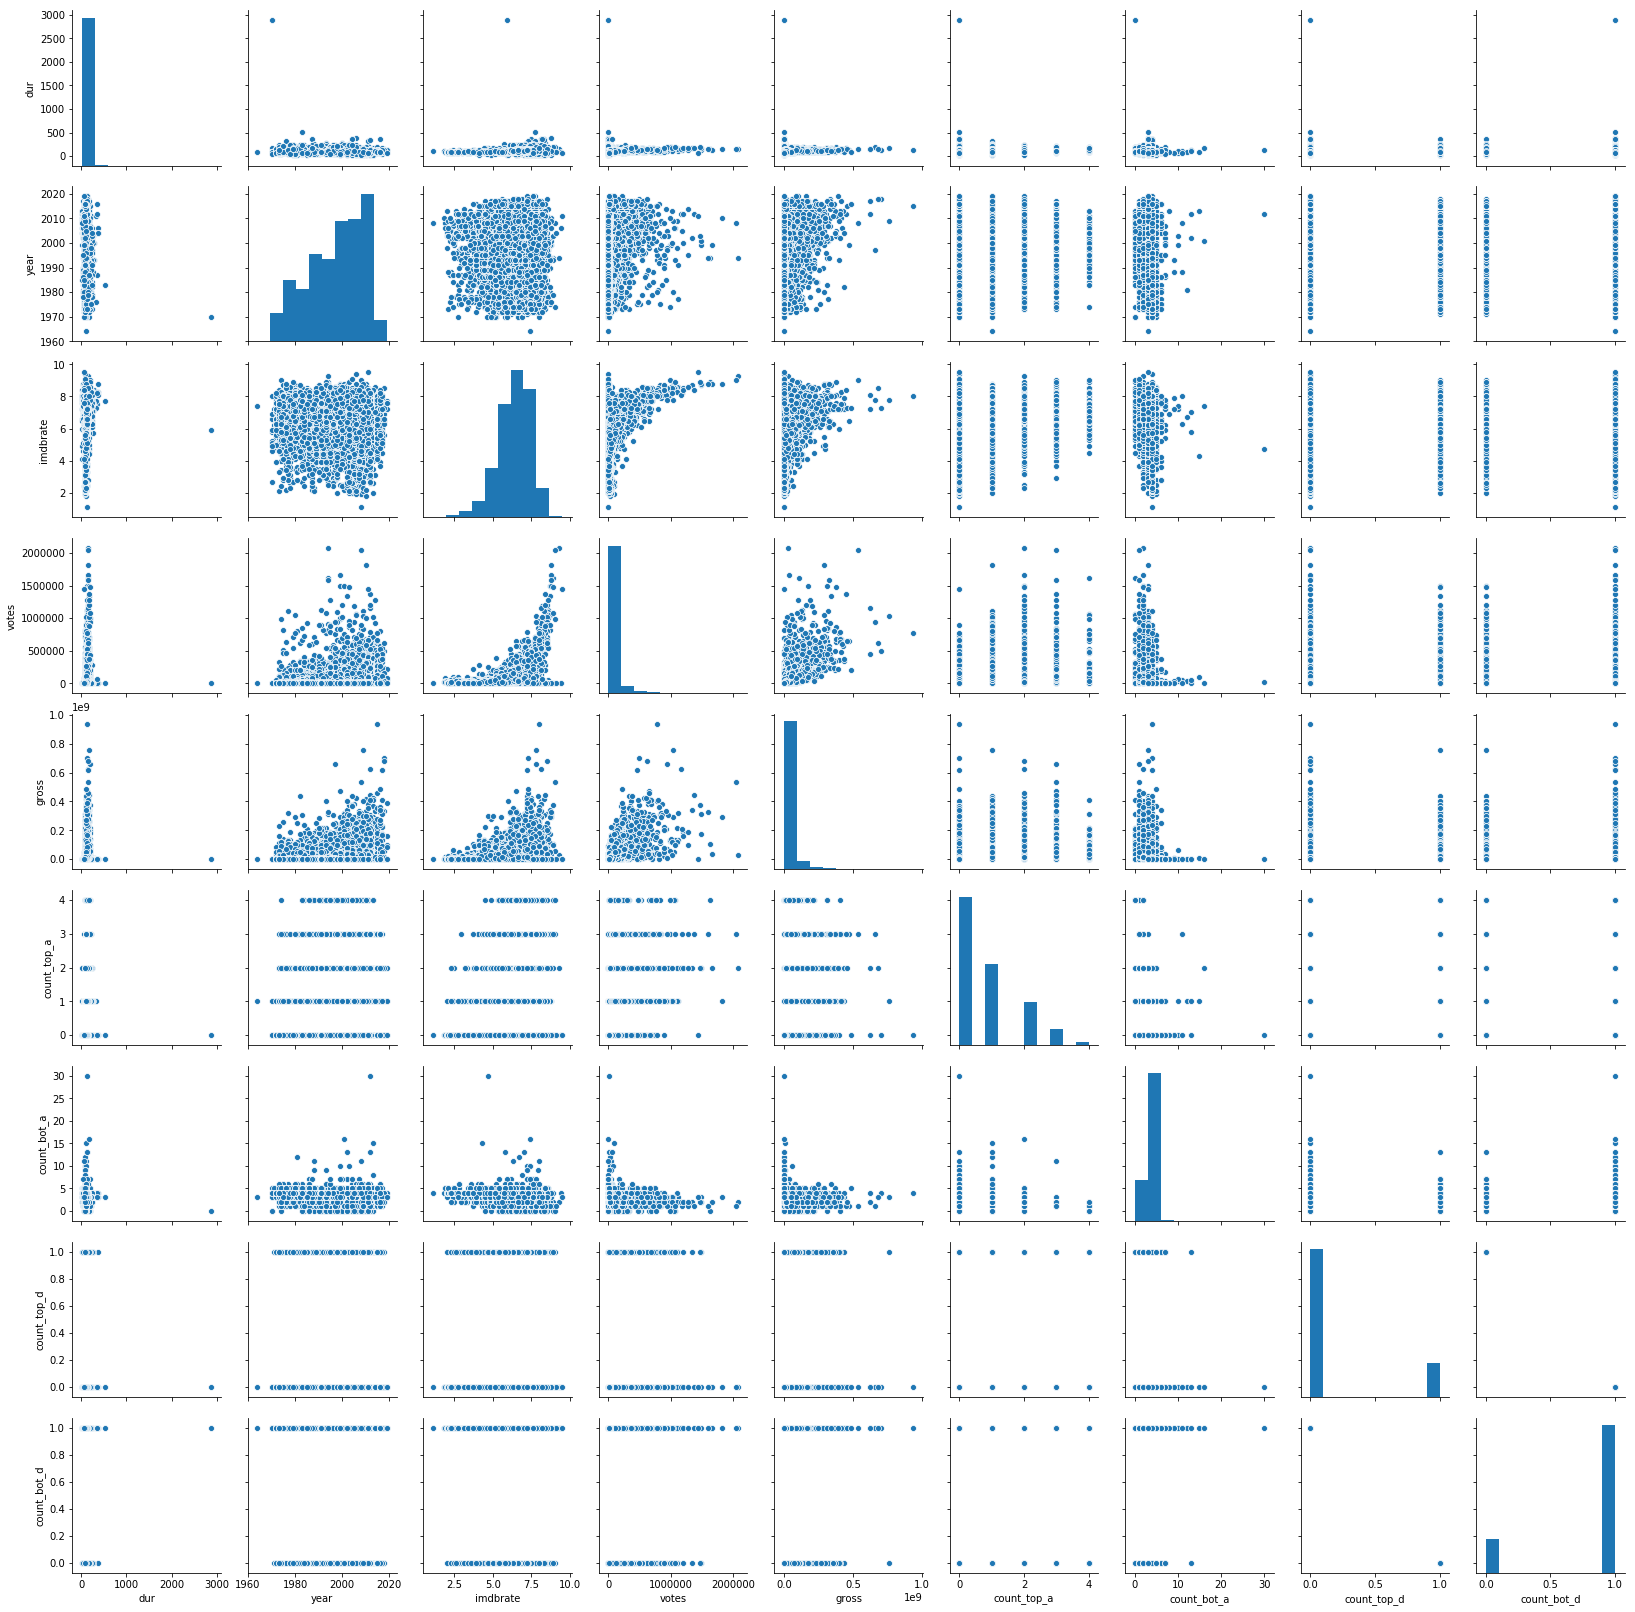

In [76]:
smaller_df= df[['dur','year','imdbrate','votes','gross','count_top_a','count_bot_a','count_top_d','count_bot_d']]
sns.pairplot(smaller_df);

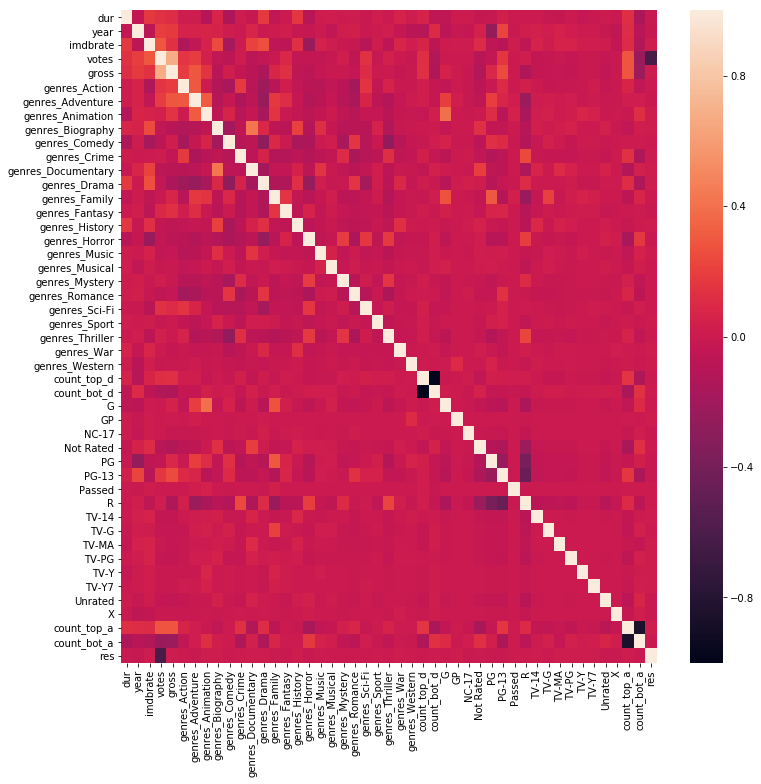

In [214]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(df.corr());

## Sanity Check

Smaller more interpretable heatmap to check if our coefficient assumptions make sense. It passes here as more popular directors and actors have a positive coefficient while less popular directors and actors have a negative coefficient.

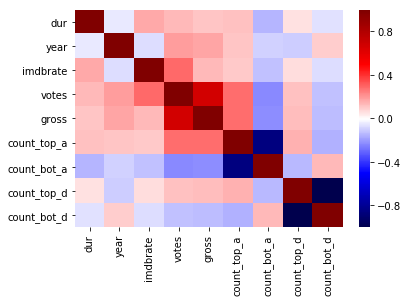

In [215]:
sns_plot=sns.heatmap(smaller_df.corr(), cmap='seismic');

In [79]:
df = df.drop(['predict','resid'],axis=1)

Again, these correlations make sense at a quick glance, and give us some interesting information, especially for genres.

In [80]:
correlations = df.corr()['votes'].sort_values(ascending=False)
correlations

votes                 1.000000
gross                 0.676473
imdbrate              0.295051
count_top_a           0.284428
year                  0.191064
genres_Adventure      0.186658
PG-13                 0.162408
genres_Action         0.150469
genres_Sci-Fi         0.138323
dur                   0.137606
count_top_d           0.120795
genres_Fantasy        0.090761
genres_Animation      0.044243
genres_Thriller       0.040274
genres_Mystery        0.026748
R                     0.018333
genres_Crime          0.012859
genres_War           -0.001660
GP                   -0.002365
Passed               -0.004016
G                    -0.004278
NC-17                -0.007310
TV-Y7                -0.008472
TV-Y                 -0.008722
TV-MA                -0.009055
X                    -0.012071
genres_Family        -0.015373
genres_Western       -0.016488
genres_Sport         -0.018994
genres_Musical       -0.019865
TV-G                 -0.026701
TV-PG                -0.034400
Unrated 

In [82]:
X_train, X_test, y_train, y_test = train_test_split(df[xlist], y, test_size=0.33, random_state=42)


In [111]:
m = LinearRegression()
m.fit(X_train,y_train)
print(m.score(X_train,y_train))
print(m.score(X_test,y_test))

0.5629389184556717
0.5319811535278791


In [96]:
m = LassoCV()
m.fit(X_train,y_train)
print(m.score(X_train,y_train))
print(m.score(X_test,y_test))

0.460936221878109
0.4513738185709666


/Users/christianbranton/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [85]:
cross_val_score(m, X_train, y_train, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric

array([0.55999012, 0.48907232, 0.51403722, 0.57995211, 0.5756685 ])

In [114]:
p = PolynomialFeatures(degree=2)
m.fit(p.fit_transform(X_train),y_train)
m.score(p.transform(X_train),y_train)

0.6498404752049045

In [113]:
p = PolynomialFeatures(degree=3)
m.fit(p.fit_transform(X_train),y_train)
m.score(p.transform(X_train),y_train)

0.5661690037565612

In [116]:
for alpha in range (1,8,1):
    m = Lasso(alpha=10**alpha)
    p = PolynomialFeatures(degree=2)
    m.fit(p.fit_transform(X_train),y_train)
    print(m.score(p.transform(X_train),y_train))
    print(sum([1 for v in m.coef_ if abs(v)>0.001]))

/Users/christianbranton/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.7589775206412409
425


/Users/christianbranton/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.749166421076185
184


/Users/christianbranton/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.7392532854934057
90


/Users/christianbranton/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.7241177414466591
62


/Users/christianbranton/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.6990617395960956
48


/Users/christianbranton/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.6892406676978453
25
0.6789819726858412
11


/Users/christianbranton/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [181]:
#Model for the training data
m = Lasso(alpha=1100)
p = PolynomialFeatures(degree=2)
std = StandardScaler()
X_tr = p.fit_transform(X_train.values)
X_tr = std.fit_transform(X_tr)
m.fit(X_tr,y_train)
print(m.score(X_tr,y_train))
print('Number of features:',sum([1 for v in m.coef_ if abs(v)>0.001]))

0.6904665094237933
Number of features: 110


In [168]:
#Testing model on test data
X_te = p.fit_transform(X_test.values)
X_te = std.fit_transform(X_te)
m.score(X_te,y_test)

0.6326732440201506

## Visualizations and Dataframe results

Put our data into a readable format of most important features and coefficients.

In [94]:
se_tr=m.predict(X_tr)-y_train
se_te=(m.predict(X_te)-y_test)
df['res'] = pd.concat([se_tr,se_te]).sort_index()

In [289]:
fin_coef=list(zip(m.coef_,p.get_feature_names(X.columns)))
newf = sorted(fin_coef, key=lambda x: x[0], reverse = True)

In [290]:
ssl = pd.DataFrame(newf)
slhead = ssl.head(15)
sltail = ssl.tail(15)
slhead
#sorted(by=slhead[0])

slhead[0] = slhead[0].astype(int)
#sltail[0] = sltail[0].astype(int)
#sltail
slhead

/Users/christianbranton/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,0,1
0,133857,imdbrate gross
1,68483,imdbrate^2
2,12465,year^2
3,12259,imdbrate R
4,11320,genres_Action TV-MA
5,8845,imdbrate count_top_a
6,6566,imdbrate genres_Sci-Fi
7,4691,gross R
8,4382,PG-13 count_bot_a
9,4030,PG count_bot_a


## Rejoin Names of Movies, Actors, etc.

We do this in order to view the movies which are most accurate and movies which are not, as well as some sample movies.

In [96]:
final_df = df.join(df2)

In [121]:
final_df['ab_res'] = abs(final_df['res'])

In [ ]:
final_df[final_df.votes>300000].sort_values(by=['ab_res'], ascending=True).head()

In [ ]:
final_df.sort_values(by=['res'], ascending=True).head()

Here we use a scatter plot to see how accurate our residuals are relative to votes. We can see that there is a non-linear pattern towards the outliers which would make this better suited for a non-linear regressor such as a RandomForest.

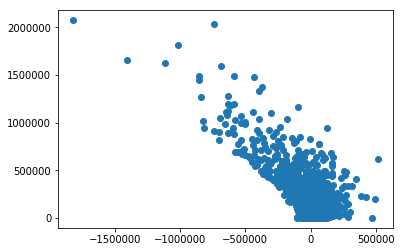

In [101]:
plt.scatter(final_df.res,final_df.votes);

## Post Project Information and Additions

The idea of this project was to focus on basic linear regressions and polynomial features but it was obvious from the results that the results were nonlinear and so using a basic RandomForestRegressor to check whether this assumption was accurate gave us a far more accurate R^2 validating this assumption.

In [124]:
from sklearn.ensemble import RandomForestRegressor

In [125]:
m = RandomForestRegressor()
m.fit(X_train,y_train)
print(m.score(X_train,y_train))
print(m.score(X_test,y_test))

/Users/christianbranton/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9675539188927106
0.8330448179020219
